## This notebook is for running the MCMC algorithm with different conditions and checking convergence

think of this as a model for what you would run in your python environment to get results

In [8]:
import numpy as np
import pandas as pd

# import main data
data_lcparam = pd.read_csv("lcparam_DS17f.txt", sep=" ")

#these are the core functions: 
#chain gives us results
#plot_chain_behaviour shows the results
#likelihood_test does a brute force sweep of the omegas to check the likelihood
from core_mcmc_functions import chain
from core_mcmc_functions import plot_chain_behaviour
from core_mcmc_functions import likelihood_test

In [10]:
#this is not necesarry to import unless you want do systematic error

# import systematic error
data_sys = pd.read_csv("sys_DS17f.txt", sep=" ")
data_sys.columns = ["sys_error"]
sys_error_data = np.reshape(pd.Series.to_numpy(data_sys.sys_error), (40, 40))

#create a likelihood function that uses the systematic error
from prior_likelihood import likelihood

def sys_error_likelihood(params, data):
    return likelihood(params, data, sys_error=sys_error_data)

## Here we run a chain

In [13]:
# here is an example chain, it will run for 10,000 steps at maximum and terminate if the mean of the parameters
# over the previous 3,000 steps is within .5% of the mean of the 3,000 steps before that
# 'convergence' is very tunable here. A 'convergence' failure dosnt mean the algorithm failed so much as
# you set number of trials too low or an unreasonalbe convergence threshhold/window.

chn, rej = chain(data_lcparam, 10000, 3000, .005, start_state=[.33, .6, 74, -19.23], variances=None, prior_mode='uniform')

#systematic error chain would look like this
#chn, rej = chain(data_lcparam, 10000, 3000, .01, start_state=[.33, .6, 74, -19.23], variances='systematic', prior_mode='M_gaussian', likelihood_func=sys_error_likelihood )



total trials:6001. accepted 44.9% of trials


## Once you have a chain, you can plot the results using this function:
    it has lots of options, detailed in the docstring

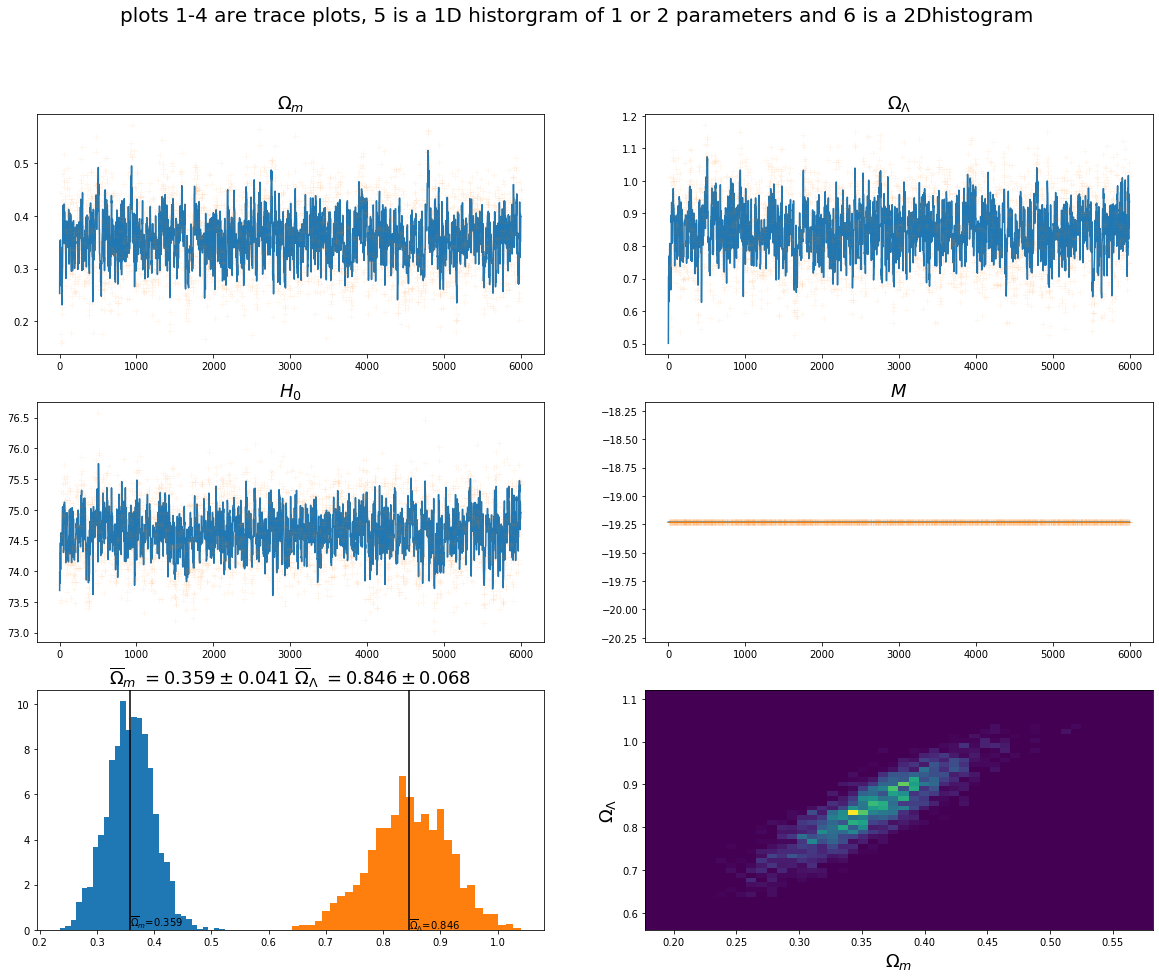

In [14]:
plot_chain_behaviour(chn, rej)

## This is a brute force likelihood test
doesnt rely on the MCMC algorithm at all, its a sanity check to see if you sampled from the posterior nicely

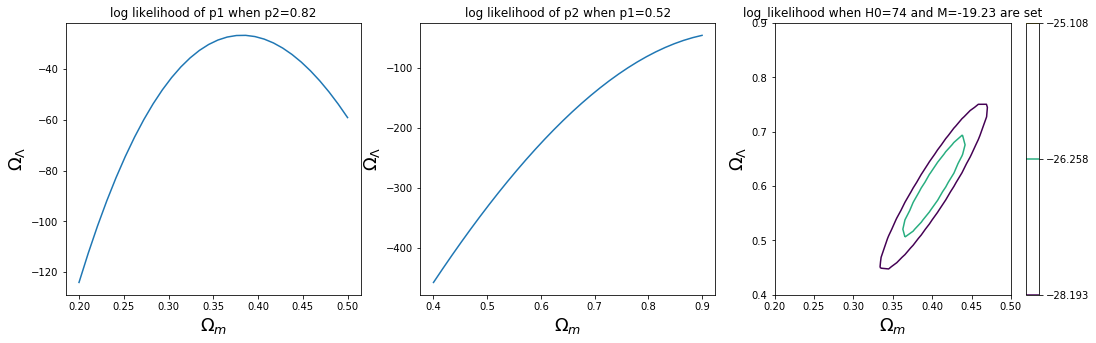

In [6]:
likelihood_test(data_lcparam, 30, .2, .5, .4, .9)

## This is if you want to make your own covariance matrix for the generating function
these commands estimate the covariance matrix from a sample chain 'chn'. You can take the result and put it into your chain algorithm by setting the keyword variances=cov if you are trying to increase convergence rates.

In [64]:
#scaling should probably be no more than 1, or you will get a very low acceptancd rate
scaling=.4
cutoff = int(len(chn[:,0])/5)
cchn = chn[cutoff:,:] 
cov=np.cov(cchn, y=None, rowvar=False)
cov=.2* cov/np.max(np.abs(cov))